# IBM Data Science Capstone Project
This is a part of IBM's 9 course specialization <a href="https://www.coursera.org/professional-certificates/ibm-data-science">avalible on Coursera</a>

## Task 1. Setup:
We have to import some major libraries that will make the project shine!

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [41]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


## Task 2. Segmenting and Clustering Neighborhoods in Toronto
Data source: [https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M]

Let's import this data via pandas

In [42]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
df = pd.read_html(url, attrs={'class':'wikitable'}) # Here we are targeting table data by HTML attribute "wikitable"
# And it seems we have the data now|

# Let's examine the data
display(df[0].head(), df[0].describe())

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


,Postal Code,Borough,Neighbourhood
count,180,180,180
unique,180,11,100
top,M1Y,Not assigned,Not assigned
freq,1,77,77


#### We can see **"Not assigned"** Boroughs and Neighborhoods. According to the task:

1. Ignore cells with a *borough* that is **Not assigned**.

2. More than one neighborhood can exist in one postal code area. They have to be combined with a comma

3. If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

#### Let's clean some data!

### 1. Let's check if cell has unassigned neighborhood
If it does have a borough - we will copy it into Neighbourhood

In [43]:


df_x = df[0][df[0]['Neighbourhood'] == 'Not assigned']
df_x = df_x[df_x['Borough']!='Not assigned']
display(df_x)


,Postal Code,Borough,Neighbourhood


As we can see, *there are no values that need to be fixed via this rule*
### 2. Let's drop rows without borough!

In [44]:
df_cleared = df[0][df[0]['Borough'] != 'Not assigned']
display("Data looks like this now: ",df_cleared.head(),"And has the following properties:", df_cleared.describe())


'Data looks like this now: '

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


'And has the following properties:'

,Postal Code,Borough,Neighbourhood
count,103,103,103
unique,103,10,99
top,M8X,North York,Downsview
freq,1,24,4


### 2. Let's Group By Borough and combine Neighbourhoods
This will bring the data into the form that is presented in assignment

In [45]:

df2 = df_cleared.groupby(['Postal Code','Borough'], as_index=False).agg(','.join)
display(df2.head())

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


#### Ok, we are almost done!
Let's look at the shape of our data:

In [46]:
df2.shape

(103, 3)

## Task 3. Now we will add coordinates to each postal code
Please, note that I am using a CSV file not to abuse API limit on Geocoder.

In [47]:
postal = pd.read_csv('Geospatial_Coordinates.csv')
display(postal.head(), postal.shape)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


(103, 3)

### Let's now add this data onto our existing dataframe
Looking at shapes, both are 103, so they will merge without any other interaction

In [48]:
df_postal = pd.merge(df2, postal)
display(df_postal.head())

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Task 4. Now we are given some freedom!
Let's do some magic!
### First, let's just place boroughs on the map
Based on their postal codes!

In [49]:
import folium

In [50]:
latitude = 43.7
longitude = -79.3849
map_ca = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, borough, postal_code in zip(df_postal['Latitude'], df_postal['Longitude'], df_postal['Borough'], df_postal['Postal Code']):
    label = '{}\n {}'.format(borough, postal_code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ca)

In [51]:
map_ca

In [52]:
a = df_postal['Borough'].unique()
display("There is total of:",len(a),"boroughs. They are:", pd.DataFrame({'Borough':a}))

'There is total of:'

10

'boroughs. They are:'

,Borough
0,Scarborough
1,North York
2,East York
3,East Toronto
4,Central Toronto
5,Downtown Toronto
6,York
7,West Toronto
8,Mississauga
9,Etobicoke


# Buisness Task
A coffee company wants to deliver fresh coffee bags to coffee machines all across Toronto.

It's a noble goal!

They need to organize logistics, so the deliveries will be made on time from different warehouses.

They have funds to open 10 warehouses. 1 in each borough. However, some boroughs are bigger than others, we need better way to determine which warehose services which area.

## Clustering
As there are 10 boroughs, let's separate the city into 10 different clusters. Our imaginary company wants 10 warehouses in Toronto, so they want to have clusters of ZIP-Codes for delivery services optimizaiton.
## We will try k-means clustering

In [53]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 10

df_postal_training = df_postal.drop(['Postal Code','Borough','Neighbourhood'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_postal_training)

# add cluster labels to dataframe:
df_postal.insert(0, 'Cluster Labels', kmeans.labels_)

In [54]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, )

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = matplotlib.cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_postal['Latitude'], df_postal['Longitude'], df_postal['Postal Code'], df_postal['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Let's check if our clustering is similar to real boroughs:
![Boroughs](./brws.bmp)

By the way, it's not my map. It was taken from Kayleigh Murphy on [Pinterest](https://www.pinterest.com/pin/144537469264022620/)

## Let's look at the plots below to see how clusters align with actual boroughs

[]

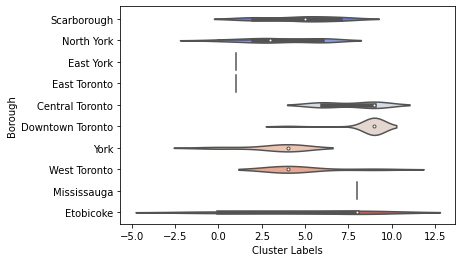

In [58]:
sns.violinplot('Cluster Labels','Borough',data=df_postal,palette='coolwarm')
plt.plot()

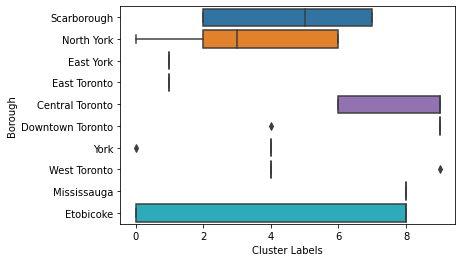

In [62]:
sns.boxplot('Cluster Labels','Borough',data=df_postal)
plt.show()

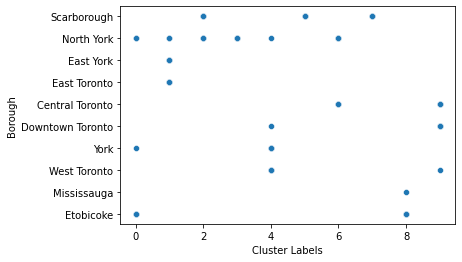

In [63]:
sns.scatterplot(df_postal['Cluster Labels'],df_postal['Borough'])
plt.show()

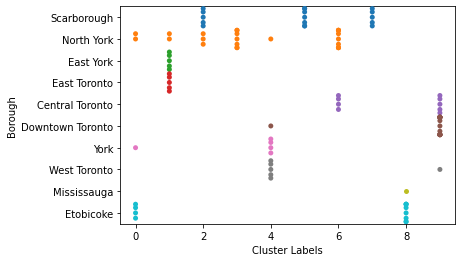

In [65]:
sns.swarmplot(df_postal['Cluster Labels'],df_postal['Borough'])
plt.show()

### As we can see, clusters don't allign with boroughs too much.

However, 10 warehouses could easily cover these 10 clusters and supply the city evenly.

We could've taken population into consideration, for even better analysis, but this will do!

# Our coffee company started opening warehouses. Let's wish them a success :)

### Thank you for looking through my code!
#### Author:
Ilya Smelyanskiy
<a href="https://www.linkedin.com/in/ilya-smelyanskiy/">LinkedIn</a>